# `aimmd.distributed.CommittorSimulation`
This notebook showcases how to steer a complete `CommittorSimulation` from python.

**This notebook should be run on a multi-core workstation preferably with a GPU**, otherwise you will have a very long coffee break and a very hot laptop.

**Required knowledge/recommended reading:** This notebook assumes familiarity with the `GmxEngine`/`SlurmGmxEngine` and the `TrajectoryFunctionWrappers` from the `asyncmd` module. Please have a look at the documentation/examples there.

### Imports and working directory

In [1]:
%%bash
# if using the module system to make gromacs and friends available:
# check that they are loaded!
#module list

In [2]:
%%bash
# unix only, check that gmx is available
which gmx

/home/think/miniforge3/envs/aimmd_dev_new/bin/gmx


In [3]:
%matplotlib inline

In [4]:
import os
import asyncio
import matplotlib.pyplot as plt
import numpy as np
import MDAnalysis as mda

/home/think/miniforge3/envs/aimmd_dev_new/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import asyncmd
import asyncmd.gromacs as async_gmx
import aimmd
import aimmd.distributed as aimmdd

Could not initialize SLURM cluster handling. If you are sure SLURM (sinfo/sacct/etc) is available try calling `asyncmd.config.set_all_slurm_settings()` or `asyncmd.config.set_slurm_setting()` with the appropriate arguments.
/home/think/Documents/sources/OPS/aimmd/aimmd/base/storage.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


In [6]:
# setup working directory

#scratch_dir = "."
scratch_dir = "/home/think/scratch/aimmd_distributed/"

workdir = os.path.join(scratch_dir, "Committors_test")

if not os.path.isdir(workdir):
    os.mkdir(workdir)

### Setup logging (optional)
Note that this is entirely optional, i.e. you can skip the next 3 cells if you like. However for now we want the loglevel to be 'INFO' to see everything/most of the stuff that is done (and possibly goes wrong).

In [7]:
# setup logging
# executing this file sets the variable LOGCONFIG, which is a dictionary of logging presets 
%run ../resources/logconf.py

In [8]:
# have a look at the default logging level (the level used for the root logger)
print(LOGCONFIG["loggers"][""])
# have a look at the logger for aimmd
print(LOGCONFIG["loggers"]["aimmd"])
# and have a look at the log-level for the filehandler
print(LOGCONFIG["handlers"]["stdf"])
# the last two should both be `INFO`

{'level': 'WARN', 'handlers': ['stdf', 'warnout']}
{'level': 'INFO'}
{'class': 'logging.FileHandler', 'level': 'INFO', 'mode': 'w', 'filename': 'simulation.log', 'formatter': 'standardFormatter'}


In [9]:
# OPTIONAL: more logging
#LOGCONFIG["handlers"]["stdf"]["level"] = "DEBUG"
#LOGCONFIG["loggers"]["aimmd"]["level"] = "DEBUG"

In [10]:
# you can either modify single values or use it as is to get the same setup as in the OPS default logging config file
# you could e.g. do LOGCONF['handlers']['stdf']['filename'] = new_name to change the filename of the log
# the default is to create 'simulation.log' and 'initialization.log' in the current working directory
import logging.config
LOGCONFIG["handlers"]["stdf"]["filename"] = os.path.join(workdir, "simulation_committors.log")
#LOGCONFIG["handlers"]["initf"]["filename"] = os.path.join(workdir, "initlog_committors.log")
logging.config.dictConfig(LOGCONFIG)

## `aimmd.distributed.CommittorSimulation` setup
The `CommittorSimulation` is a python class to steer/control multiple molecular simulations at the same time. It takes a list of starting configurations and the states to then propagate the trajectories (usually in chunks of walltime) until any of the states is reached. It supports oneway and twoway shooting (the later not beeing a true committor simulation because forward and backwards trajectories are correlated) and is the highlevel user-facing object to perform committor simulations.

To initialize and run a `CommittorSimulation` you need:
- `workdir`: The toplevel directory the simulation will run in
- `starting_configurations`: A list, every entry in the list corresponds to one configuration and must be an iterable itself, the single list entry structure is: `aimmd.distributed.Trajectory`, `index_of_conf_in_traj`, `name_for_configuration`; Note that the `name_for_configuration` is optional and will be used only as the name of the (sub)folder in which the trials for that configuration will be performed, if no name is supplied the folder will simply be named `configuration_$CONFNUM`
- `states`: A list of state functions, preferably wrapped using a `aimmd.distributed.TrajectoryFunctionWrapper`
- `engine_cls`: The class of the molecular dynamics engine to use, should be a sublcass of `aimmd.distributed.MDEngine`
- `engine_kwargs`: A dictionary with keyword arguments that can/will be used to instatiate the molecular dynamics engine
- `T`: float, the temperature to use when generating random Maxwell-Boltzmann velocities
- `walltime_per_part`: float, (maximum) walltime per trajectory segment in hours; Note that this does not determine the total length of the trajectories but only the size of the single trajectory segments
- `n_max_concurrent`: int, the maximum number of trials to propagate concurrently; Note for two way simulations you will run 2*`n_max_concurrent` molecular dynamic simulations in parallel
- `two_way`: wheter to run molecular dymaics forward and backward in time
- `max_steps`: int or None, the maximum number of integration steps to perform in total per trajectory, i.e. for two way simulations the combined maximum length of the resulting trajectory will be 2*`max_steps`

Note that you can set all attributes of the `CommittorSimulation` (`fname_traj_to_state`, `fname_transition_traj`, `deffnm_engine_out`, etc.) at initialization time by passing them as keyword arguments with the respective values you want to use.


Also Note, that the `CommittorSimulation` is quite flexible and allows the simulation of different physical ensembles for every starting configuration. This is achieved by allowing the parameters `engine_cls`, `engine_kwargs`, `T` and `twoway` to be either single instances (i.e. using the same value for the whole committor simulation) or a list with the same length as `starting_configurations` (i.e. one value per starting configuration). This means you can simulate systems differing in the number of molecules (by changing the topology used in the engine), at different pressures (by changing the molecular dynamics parameters passed with `engine_kwargs`), at different temperatures (by changing `T` and the parameters in the `engine_kwargs`) and even perform two way shots only for a selected subset of starting configurations (e.g. the ones you expect to be a transition state).

If the `CommittorSimulation` options still are not flexible enough for your needs you can always use the `asyncmd.trajectory.TrajectoryPropagatorUntilAnyState` (which is used under the hood anyway) to implement your own committor simulation from scratch.

In [11]:
# import state functions
from state_funcs_mda import alpha_R, C7_eq

# and wrapp them
wrapped_alphaR = asyncmd.trajectory.PyTrajectoryFunctionWrapper(alpha_R)
wrapped_C7_eq = asyncmd.trajectory.PyTrajectoryFunctionWrapper(C7_eq)

In [12]:
# Load the transition to take initial configurations from 
tp_traj = asyncmd.Trajectory(trajectory_files="gmx_infiles/TP_low_barrier_300K_amber99sbildn.trr",
                             structure_file="gmx_infiles/conf.gro")
print(f"The transition has a length of {len(tp_traj)} frames.")

The transition has a length of 102 frames.


In [13]:
from aimmd.distributed.committors_new import (CommittorConfiguration,
                                              CommittorSimulation,
                                              CommittorEngineSpec,
                                              )

In [14]:
# prepare a list of starting configurations
# we will take each frame of the transition once except the first and last frame (these are already inside the states)
# OPTIONAL: we will name each configuration 'frame$FRAMENUM_from_low_barrier_transition',
#           we could also just have used tuples of length 2: (traj, idx) and then every configuration would just get an index
starting_confs = [CommittorConfiguration(trajectory=tp_traj,
                                         index=i,
                                         name=f"frame{i}_from_low_barrier_transition",
                                         )
                  for i in range(5, len(tp_traj) - 1, 10)
                  ]
print(f"Selected {len(starting_confs)} frames as starting configurations.")

Selected 10 frames as starting configurations.


In [15]:
# have a look at the results of our state functions (note that the transition is from a slightly less strict alpha_R function)
await wrapped_alphaR(tp_traj)

array([ True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [16]:
await wrapped_C7_eq(tp_traj)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True])

In [17]:
# engine_kwargs
gro = "gmx_infiles/conf.gro"
top = "gmx_infiles/topol_amber99sbildn.top"
ndx = "gmx_infiles/index.ndx"
mdp = async_gmx.MDP("gmx_infiles/md.mdp")
#mdp["nstxout"] = 10
#mdp["nstvout"] = 10


print(f"The reference temperature ('ref-t') in the mdp file is: {mdp['ref-t']}.")

engine_kwargs = {"mdconfig": mdp, "gro_file":gro, "top_file":top, "ndx_file":ndx,
                 #"mdrun_extra_args":"-nt 1",  # use this for GMX with (thread) MPI support
                 "mdrun_extra_args": "-nt 2",  # and this for GMX sans (thread) MPI support
                 "output_traj_type": "XTC",
                 }

committor_engine_spec = CommittorEngineSpec(
                                engine_cls=async_gmx.GmxEngine,
                                engine_kwargs=engine_kwargs,
                                walltime_per_part=0.000015625,  # 0.055125 s per part
                                #walltime_per_part=0.000125,  # 0.45 s per part
                                #walltime_per_part=0.005,  # run in simulation parts of 18 seconds
                                
                                )

# here we simply use the `singleton` options for all configurations,
# i.e. all molecular dynamics simulations of this committor simulation sample the same ensemble
simulation = CommittorSimulation(workdir=workdir,
                                 configurations=starting_confs,
                                 states=[wrapped_alphaR, wrapped_C7_eq],
                                 temperature=mdp["ref-t"][0],
                                 committor_engine_spec=committor_engine_spec,
                                 two_way=False,
                                 ######################### TODO: test this?!
                                 max_retries_on_max_steps=2,
                                 # maximum number of retries on crash, e.g. 5 means try at most 6 times
                                 #########################
                                 )

The reference temperature ('ref-t') in the mdp file is: [300.0, 300.0].


In [18]:
print(mdp)

<class 'asyncmd.gromacs.mdconfig.MDP'> has been changed since parsing: True
Current content:
----------------
title : ['test']
cpp : ['/lib/cpp']
include : ['-I../top']
define : []
integrator : md-vv
dt : 0.002
nsteps : -1
nstxout : 0
nstvout : 0
nstlog : 20
nstxout-compressed : 20
nstlist : 50
ns-type : grid
cutoff-scheme : Verlet
rlist : 1.1
coulombtype : PME
rcoulomb : 1.1
rvdw : 1.1
tcoupl : v-rescale
tc-grps : ['Protein', 'SOL']
tau-t : [0.5, 0.5]
ref-t : [300.0, 300.0]
Pcoupl : C-rescale
tau-p : 1.0
compressibility : [4.5e-05]
ref-p : [1.0]
gen-vel : no
gen-temp : 300.0
gen-seed : 173529
constraints : h-bonds
continuation : yes



In [19]:
# now run the simulation for 10 shots per configuration
await simulation.run(10, n_max_concurrent=None)
# if there are errors below they probably stem from the fact that the transition contains 4 frames in alphaR (the state with index 0)
# therefore the TrajectoryPropagatorUntilAnyState raises an error and returns the starting configuration as a len 1 trajectory
# (the error is raised because usually something went wrong if the first frame already fulfills the stopping criteria)

100%|██████████| 100/100 [00:33<00:00,  2.99it/s]


## Have a look at and plot the results

In [20]:
import matplotlib

### Plot results for every shot seperately, i.e. each result separately 

Text(0, 0.5, 'State reached')

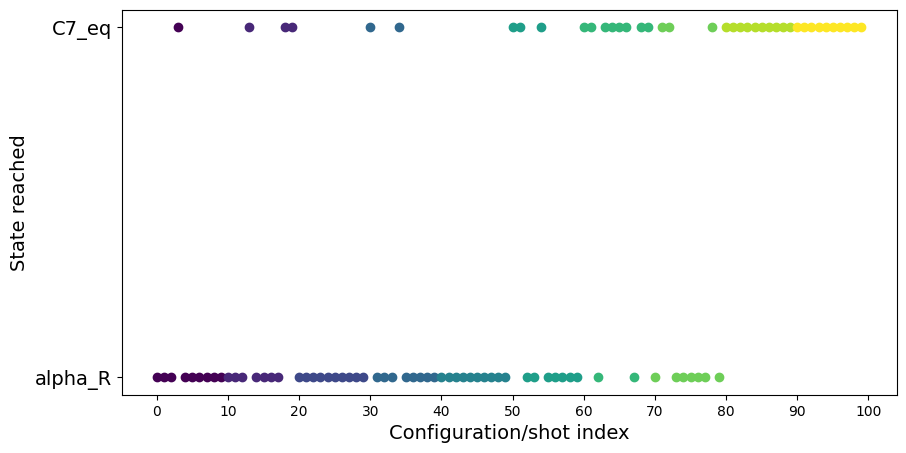

In [21]:
fig, axs = plt.subplots(figsize=(10, 5))

# look at the shooting results per stucture and trial,
# i.e. it has shape = (n_conf, n_trial, n_states)
# it can be accessed as `CommittorSimulation.states_reached_per_shot`
n_conf, n_shot, n_states = simulation.states_reached_per_trial.shape
xses_per_conf = np.arange(0, n_shot)
# get a colorbar and a normalize instance to have different colors for starting structure
cmap = matplotlib.colormaps.get_cmap("viridis")
norm = matplotlib.colors.Normalize(vmin=0, vmax=n_conf-1)

for cnum, conf in enumerate(simulation.states_reached_per_trial):
    # NOTE: this only works if ret is per configuration and per shot, i.e. if it can only have one True value (one 1) per array in the last axis
    plot_vals = np.full((n_shot,), np.nan)  # fill with the plot values
    idxs, state = np.where(conf)  # will return the idxs of the shot and idx of the state each shot reached
    plot_vals[idxs] = state
    axs.scatter(x=xses_per_conf + (n_shot * cnum),
                y=plot_vals,
                color=cmap(norm(cnum)),
                )

axs.set_yticks([i for i in range(n_states)])
axs.set_yticklabels(["alpha_R", "C7_eq"], size=14)
axs.set_xticks([n_shot * i for i in range(n_conf + 1)])
axs.set_xlabel("Configuration/shot index", size=14)
axs.set_ylabel("State reached", size=14)

### Plot committor estimates for every starting configuration, i.e. aggregated for every starting structure

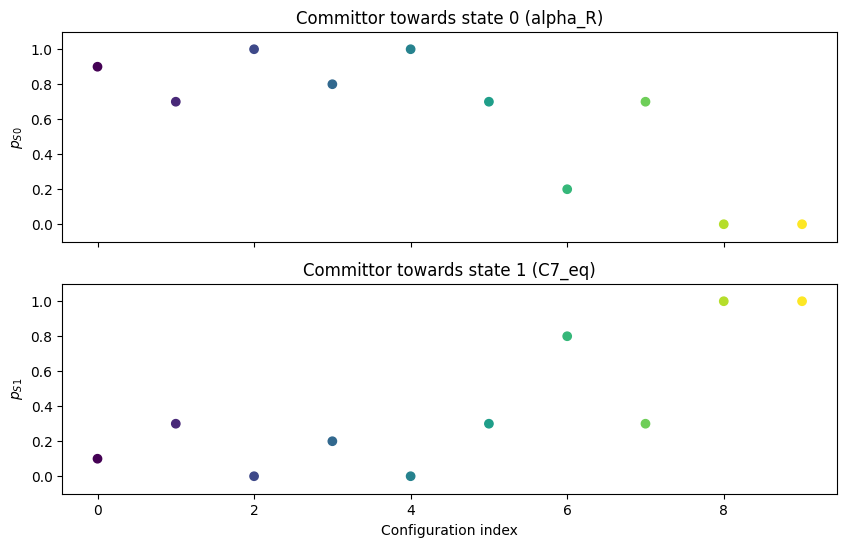

In [22]:
fig, axs = plt.subplots(figsize=(10,6), nrows=n_states, sharex=True)
# states_reached already aggregates the result for the same starting configuration
# it therefore has shape = (n_conf, n_states)
n_conf, n_states = simulation.states_reached.shape
for snum, (ax, name) in enumerate(zip(axs, ["alpha_R", "C7_eq"])):
    ax.set_title(f"Committor towards state {snum} ({name})")
    ax.scatter(x=np.arange(n_conf),
               y=simulation.states_reached[:, snum] / np.sum(simulation.states_reached, axis=1),
               c=cmap(norm(np.arange(n_conf))),
               )
    ax.set_ylim(-0.1, 1.1)
    ax.set_ylabel(f"$p_{{S{snum}}}$")
    if snum == 1:
        ax.set_xlabel("Configuration index")

## Add "backwards" shots to generate initial transitions
We will now add the conjugate "backwards" trials for the most promising configurations, i.e. thoose with shots that reached both states. To this end we will initialize a new committor simulation with only those configurations and use its `reinitialize_from_workdir()` method. We will set `twoway=True` to add the backwards shots for all of the configurations we now look at again. The `CommittorSimulation` will then add the missing backwards trials to all configurations it knows about. Note, that using a subset of the configurations only works since we named the configurations, if we had not done so we could still add the backwards shots, but would need to do so for all configurations (at least up to a given configuration number).

In addition to adding the missing backwards shots this will also write out any potentially generated transitions as one concatenated trajectory from the lower index state to the higher index state with the first and last frame in the states. Therfore the twoway shooting can be used to generate initial transitions for a subsequent transition path sampling simulation. Note however that this is usually only smart for configurations that have an roughly equal probability to reach both/multiple states, i.e. for potential transition states.

In [23]:
p_c7_eq = simulation.states_reached[:, 1] / np.sum(simulation.states_reached, axis=1)
print(np.where((0.25 < p_c7_eq) & (p_c7_eq < 0.75)))

two_way = [False for _ in range(len(simulation.configurations))]
for idx in np.where((0.25 < p_c7_eq) & (p_c7_eq < 0.75))[0]:
    two_way[idx] = True

print(two_way)

#confs_for_twoway = []
#for sconf, p in zip(starting_confs, p_c7_eq):
#    if 0.25 <= p <= 0.75:
#        confs_for_twoway += [sconf]
#print(f"Selected {len(confs_for_twoway)} promising configurations with p(TP|x) >= {round(2 * 0.25**2, 3)}.")

(array([1, 5, 7]),)
[False, True, False, False, False, True, False, True, False, False]


In [24]:
simulation.configurations[6]

CommittorConfiguration(trajectory=Trajectory(trajectory_files=gmx_infiles/TP_low_barrier_300K_amber99sbildn.trr, structure_file=gmx_infiles/conf.gro), index=65, name='frame65_from_low_barrier_transition')

In [25]:
simulation.two_way = two_way

(WARNING)aimmd.distributed.committors_new two_way: Changing two_way after trials have been performed.Please call `add_missing_backward_trials` method to ensure consistency.


In [26]:
await simulation.add_missing_backward_trials()

100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


## Accessing the generated trajectories
The concatenated trajectories until a state is reached and the potentially generated transition trajectories are all inside the respective `shot_$SHOTNUM` folders, however they can also be accessed from python via the properties `CommittorSimulation.trajs_to_state`, `CommittorSimulation.trajs_to_state_bw` and `CommittorSimulation.transitions`.

In [27]:
# show only the traj_to_state for first configuration this simulation knows about
simulation.trajectories_to_state

[[Trajectory(trajectory_files=../../../../../../scratch/aimmd_distributed/Committors_test/frame5_from_low_barrier_transition/trial_0/trajectory_to_state.xtc, structure_file=gmx_infiles/conf.gro),
  Trajectory(trajectory_files=../../../../../../scratch/aimmd_distributed/Committors_test/frame5_from_low_barrier_transition/trial_1/trajectory_to_state.xtc, structure_file=gmx_infiles/conf.gro),
  Trajectory(trajectory_files=../../../../../../scratch/aimmd_distributed/Committors_test/frame5_from_low_barrier_transition/trial_2/trajectory_to_state.xtc, structure_file=gmx_infiles/conf.gro),
  Trajectory(trajectory_files=../../../../../../scratch/aimmd_distributed/Committors_test/frame5_from_low_barrier_transition/trial_3/trajectory_to_state.xtc, structure_file=gmx_infiles/conf.gro),
  Trajectory(trajectory_files=../../../../../../scratch/aimmd_distributed/Committors_test/frame5_from_low_barrier_transition/trial_4/trajectory_to_state.xtc, structure_file=gmx_infiles/conf.gro),
  Trajectory(traject

In [28]:
simulation.trial_counter

10

In [29]:
# same here
simulation.trajectories_to_state_backward

[[],
 [Trajectory(trajectory_files=../../../../../../scratch/aimmd_distributed/Committors_test/frame15_from_low_barrier_transition/trial_0/trajectory_to_state_backward.xtc, structure_file=gmx_infiles/conf.gro),
  Trajectory(trajectory_files=../../../../../../scratch/aimmd_distributed/Committors_test/frame15_from_low_barrier_transition/trial_1/trajectory_to_state_backward.xtc, structure_file=gmx_infiles/conf.gro),
  Trajectory(trajectory_files=../../../../../../scratch/aimmd_distributed/Committors_test/frame15_from_low_barrier_transition/trial_2/trajectory_to_state_backward.xtc, structure_file=gmx_infiles/conf.gro),
  Trajectory(trajectory_files=../../../../../../scratch/aimmd_distributed/Committors_test/frame15_from_low_barrier_transition/trial_3/trajectory_to_state_backward.xtc, structure_file=gmx_infiles/conf.gro),
  Trajectory(trajectory_files=../../../../../../scratch/aimmd_distributed/Committors_test/frame15_from_low_barrier_transition/trial_4/trajectory_to_state_backward.xtc, str

In [30]:
# and the transition trajectories (for the trials where we added them via two_way=True)
# we look at all of them, but there will be many empty lists for the configurations that do not have
# a backward trial
simulation.transition_trajectories

[[],
 [Trajectory(trajectory_files=../../../../../../scratch/aimmd_distributed/Committors_test/frame15_from_low_barrier_transition/trial_3/transition_trajectory.xtc, structure_file=gmx_infiles/conf.gro),
  Trajectory(trajectory_files=../../../../../../scratch/aimmd_distributed/Committors_test/frame15_from_low_barrier_transition/trial_8/transition_trajectory.xtc, structure_file=gmx_infiles/conf.gro),
  Trajectory(trajectory_files=../../../../../../scratch/aimmd_distributed/Committors_test/frame15_from_low_barrier_transition/trial_9/transition_trajectory.xtc, structure_file=gmx_infiles/conf.gro)],
 [],
 [],
 [],
 [Trajectory(trajectory_files=../../../../../../scratch/aimmd_distributed/Committors_test/frame55_from_low_barrier_transition/trial_0/transition_trajectory.xtc, structure_file=gmx_infiles/conf.gro),
  Trajectory(trajectory_files=../../../../../../scratch/aimmd_distributed/Committors_test/frame55_from_low_barrier_transition/trial_1/transition_trajectory.xtc, structure_file=gmx_inf

## "Continuation" of the trials that reached only one state
This is a bit stupid, but just to showcase the possiblity to rerun a `CommittorSimulation` on an existing directory/run with possibly changed states. To this end, we will simply run the `CommittorSimulation` with only one state (the one we did not reach on the trials we rerun on). We will take the first few trials (started from configurations on the transition that are close(r) to alpha_R) as they should all/mostly have reached the alpha_R state and run a committor continuation with C7_eq as the only target state. This will result in continuing all choosen trial until they reach C7_eq (ignoring that they first reached alpha_R because the new `CommittorSimulation` does not know about alpha_R anymore).

In [31]:
# take the first 5 starting configurations for continuation, they will mostly have ended up in C7_eq
first_n_starting_configurations_to_take = 5

In [32]:
new_simulation = CommittorSimulation(workdir=workdir,
                                     # take only a subset of the original starting configurations
                                     # NOTE: we exclude the first frame because it is already inside alpha_R, i.e. we never
                                     #       started a trajectory for these shots, therefore the continuation will fail...
                                     configurations=starting_confs[:first_n_starting_configurations_to_take],
                                     states=[wrapped_C7_eq], # only C7_eq as target state
                                     temperature=mdp["ref-t"][0],
                                     committor_engine_spec=committor_engine_spec,
                                     # make sure we name the concatenated output trajs differently this time
                                     fileout_trajectory_to_state="continuation_traj_to_state",
                                     # not needed since we dont do twoway, but for completeness
                                     fileout_trajectory_to_state_backward="continuation_traj_to_state_bw",
                                     # also not really needed, there can be no transitions with only one state anyway
                                     fileout_transition_trajectory="transition_traj",
                                            )

In [33]:
# since the concatenated output-trajs have different names we can pass overwrite=False
#  (the default is True!)
await new_simulation.reinitialize_from_workdir(overwrite=False, n_max_concurrent=20)

100%|██████████| 50/50 [16:39<00:00, 19.98s/it]


In [34]:
new_simulation.states_reached

array([[10.],
       [10.],
       [10.],
       [10.],
       [10.]])